In [1]:
from tensorflow import keras
from PIL import Image
import cv2
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

### Load Test Dataset

In [2]:
X_resize = np.load('./X_resize_test.npy')
y_resize = np.load('./y_resize_test.npy')

In [3]:
X_resize.shape, y_resize.shape

((10, 1456, 2576, 3), (10, 1456, 2576, 3))

### Load Model

In [4]:
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [5]:
model = keras.models.load_model("./denoiserEnhancerSRGB.h5",{"PSNR":PSNR})

### Max PSNR Output

In [126]:
X = X_resize[8]
y = y_resize[8]

In [127]:
X.shape

(1456, 2576, 3)

In [128]:
extracted_patches = tf.image.extract_patches(images=tf.expand_dims(X ,0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
X_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))

In [129]:
extracted_patches = tf.image.extract_patches(images=tf.expand_dims(y,0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
y_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))

In [130]:
res = model.predict(np.array(X_patches))

10/10 [==============================] - 1s 119ms/step


In [131]:
patch_size = 112
n_col,n_row,n_channel = (1456, 2576, 3)
n_patch = n_row*n_col // (patch_size**2) #assume square patch

# patches = tf.image.extract_patches(np.array([X]),sizes=[1,patch_size,patch_size,1],strides=[1,patch_size,patch_size,1],rates=[1, 1, 1, 1],padding='VALID')
patches = tf.reshape(res,[n_patch,patch_size,patch_size,n_channel])

rows = tf.split(patches,n_col//patch_size,axis=0)
rows = [tf.concat(tf.unstack(x),axis=1) for x in rows] 

reconstructed_X = np.array(tf.concat(rows,axis=0))

In [132]:
patch_size = 112
n_col,n_row,n_channel = (1456, 2576, 3)
n_patch = n_row*n_col // (patch_size**2) #assume square patch

# patches = tf.image.extract_patches(np.array([X]),sizes=[1,patch_size,patch_size,1],strides=[1,patch_size,patch_size,1],rates=[1, 1, 1, 1],padding='VALID')
patches = tf.reshape(y_patches,[n_patch,patch_size,patch_size,n_channel])

rows = tf.split(patches,n_col//patch_size,axis=0)
rows = [tf.concat(tf.unstack(x),axis=1) for x in rows] 

reconstructed_y = np.array(tf.concat(rows,axis=0))

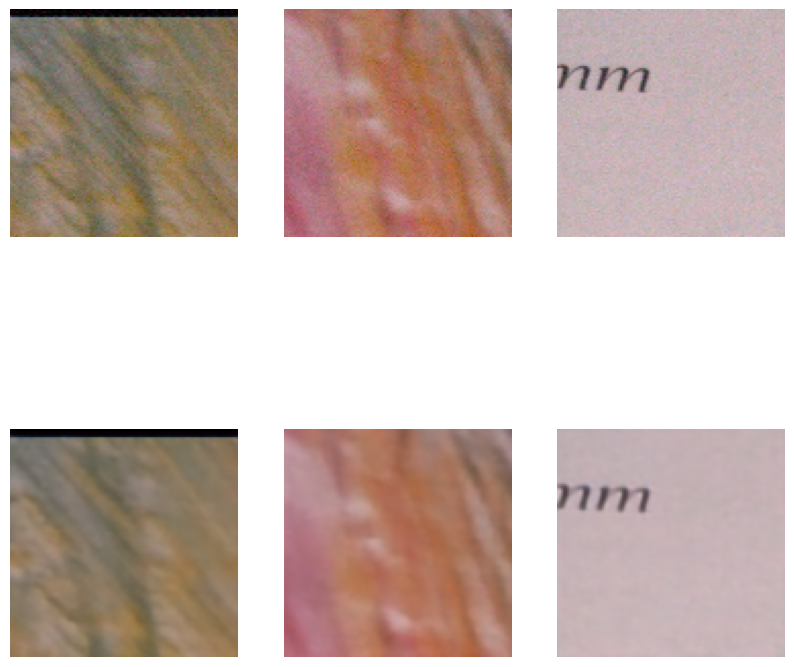

In [133]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,10))
axes[0][0].axis('off')
axes[0][0].imshow(X_patches[20])
axes[0][1].axis('off')
axes[0][1].imshow(X_patches[40])
axes[0][2].axis('off')
axes[0][2].imshow(X_patches[80])
axes[1][0].axis('off')
axes[1][0].imshow(res[20])
axes[1][1].axis('off')
axes[1][1].imshow(res[40])
axes[1][2].axis('off')
axes[1][2].imshow(res[80])

In [134]:
print(PSNR(y_patches[20],X_patches[20]))
print(PSNR(y_patches[40],X_patches[40]))
print(PSNR(y_patches[80],X_patches[80]))
print(PSNR(y_patches[20],res[20]))
print(PSNR(y_patches[40],res[40]))
print(PSNR(y_patches[80],res[80]))

tf.Tensor(30.81160449981619, shape=(), dtype=float64)
tf.Tensor(31.287906368291768, shape=(), dtype=float64)
tf.Tensor(32.84301486345062, shape=(), dtype=float64)
tf.Tensor(37.191394366389616, shape=(), dtype=float64)
tf.Tensor(38.22678945211149, shape=(), dtype=float64)
tf.Tensor(39.19409573332762, shape=(), dtype=float64)


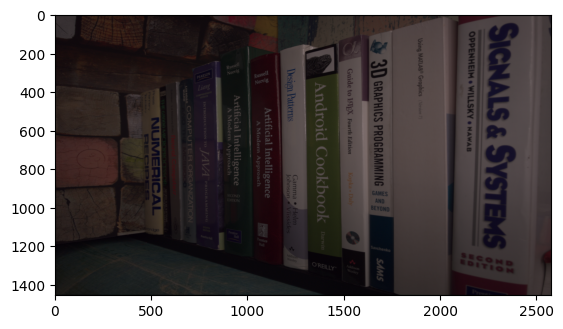

In [59]:
plt.imshow(reconstructed_y)

In [44]:
PSNR(reconstructed_y,reconstructed_X)

<tf.Tensor: shape=(), dtype=float64, numpy=41.25419413223021>

### Average PSNR Output

In [15]:
import skimage

In [16]:
def reconPatches(img):
    
    patch_size = 112
    n_col,n_row,n_channel = (1456, 2576, 3)
    n_patch = n_row*n_col // (patch_size**2)
    patches = tf.reshape(img,[n_patch,patch_size,patch_size,n_channel])
    rows = tf.split(patches,n_col//patch_size,axis=0)
    rows = [tf.concat(tf.unstack(x),axis=1) for x in rows] 
    recon = np.array(tf.concat(rows,axis=0))

    return recon

In [17]:
avg_sum=0
for i in range(10):
    extracted_patches = tf.image.extract_patches(images=tf.expand_dims(X_resize[i],0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
    X_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))
    extracted_patches = tf.image.extract_patches(images=tf.expand_dims(y_resize[i],0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
    y_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))

    res = model.predict(np.array(X_patches))

    reconstructed_X = reconPatches(res)
    reconstructed_y = reconPatches(y_patches)

    avg_sum += PSNR(reconstructed_y,reconstructed_X)

print(avg_sum/10)

10/10 [==============================] - 1s 91ms/step
tf.Tensor(39.50148010907847, shape=(), dtype=float64)


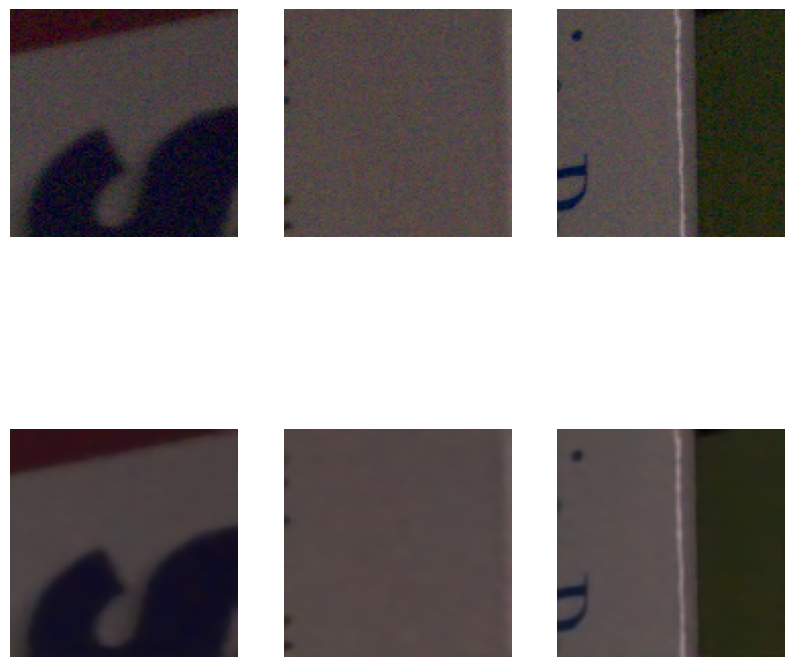

In [64]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,10))
axes[0][0].axis('off')
axes[0][0].imshow(X_patches[20])
axes[0][1].axis('off')
axes[0][1].imshow(X_patches[40])
axes[0][2].axis('off')
axes[0][2].imshow(X_patches[80])
axes[1][0].axis('off')
axes[1][0].imshow(res[20])
axes[1][1].axis('off')
axes[1][1].imshow(res[40])
axes[1][2].axis('off')
axes[1][2].imshow(res[80])

tf.Tensor(27.46769294854583, shape=(), dtype=float64)
tf.Tensor(27.62858645560739, shape=(), dtype=float64)
tf.Tensor(29.79211623072855, shape=(), dtype=float64)
tf.Tensor(35.9257341454974, shape=(), dtype=float64)
tf.Tensor(36.58886411902069, shape=(), dtype=float64)
tf.Tensor(37.99253596582658, shape=(), dtype=float64)
